## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**Vulcan Fossil Fuel CO₂ Emissions**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/vulcan-ffco2-yeargrid-v4_User_Notebook_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**:  Contiguous United States
- **Spatial resolution**: 1 km x 1 km
- **Temporal extent**: 2010 - 2021
- **Temporal resolution**: Annual
- **Unit**: Metric tons of carbon dioxide per 1 km x 1 km grid cell per year
- **Utility**: Climate Research

For more, visit the [Vulcan Fossil Fuel CO₂ Emissions](https://earth.gov/ghgcenter/data-catalog/vulcan-ffco2-yeargrid-v4) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Vulcan Fossil Fuel CO₂ Emissions Data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data
### Vulcan Fossil Fuel CO<sub>2</sub> Emissions, Version 4

The Vulcan version 4.0 data product represents total carbon dioxide (CO2) emissions resulting from the combustion of fossil fuel (ff) for the contiguous United States and District of Columbia. Referred to as ffCO2, the emissions from Vulcan are also categorized into 10 source sectors including; airports, cement production, commercial marine vessels, commercial, power plants, industrial, non-road, on-road, residential and railroads. Data are gridded annually on a 1-km grid for the years 2010 to 2021. These data are annual sums of hourly estimates. Shown is the estimated total annual ffCO2 for the United States, as well as the estimated total annual ffCO2 per sector.

For more information regarding this dataset, please visit the [Vulcan Fossil Fuel CO₂ Emissions, Version 4](https://earth.gov/ghgcenter/data-catalog/vulcan-ffco2-yeargrid-v4) data overview page.

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. Vulcan v4.0
- `item`:       One granule in the dataset, e.g. one annual file of fossil fuel CO<sub>2</sub> emissions
- `asset`:      A variable available within the granule, e.g. CO<sub>2</sub> emissions from residential buildings, airports, or cement
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching metadata about available datasets
- `Raster API`: Endpoint for fetching data itself, for imagery and statistics

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
# For fetching from the Raster API
import requests
# For making maps
import folium
import folium.plugins
from folium import Map, TileLayer
# For talking to the STAC API
from pystac_client import Client
# For working with data
import pandas as pd
# For making time series
import matplotlib.pyplot as plt
# For formatting date/time data
import datetime
# Custom functions for working with GHGC data via the API
import ghgc_utils

## Query the STAC API
**STAC API Collection Names**

Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for the Vulcan Fossil Fuel CO<sub>2</sub> Emissions, Version 4 dataset is [**vulcan-ffco2-yeargrid-v4**](https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4).*

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in the STAC collection.
# Name of the collection for Vulcan Fossil Fuel CO₂ Emissions, Version 4. 
collection_name = "vulcan-ffco2-yeargrid-v4"

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library enables an HTTP request
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=vulcan-ffco2-yeargrid-v4>

Examiningthe contents of the `collection` under the `temporal` variable, we see that the data is available from January 2011 to December 2021. Looking at the `dashboard:time density`, the data is periodic with year time density.

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 12 items


In [5]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=vulcan-ffco2-yeargrid-v4-2021>

In [7]:
# Restructure our items into a dictionary where keys are the datetime items
# Then we can query more easily by date/time, e.g. "2020"
items_dict = {item.properties["start_datetime"][:4]: item for item in collection.get_items()}

In [8]:
# Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# We'll focus on total CO2 emissions here, so our asset of interest is:
asset_name = "total-co2"

# Creating Maps Using Folium

You will now explore changes in CO<sub>2</sub> emissions at a given location and time and visualize the outputs on a map using `folium`.


## Fetch Imagery from Raster API
Here we get information from the `Raster API` which we will add to our map in the next section.

In [9]:
# Specify two date/times that you would like to visualize, using the format of items_dict.keys()
dates = ["2021","2011"]

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as the `rescale_values`, and will be passed to the Raster API in the following step(s).

In [10]:
# Extract collection name and item ID for the first date
first_date = items_dict[dates[0]]
collection_id_1 = first_date.collection_id
item_id_1 = first_date.id
# Select relevant asset
object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print raster bands' information
raster_bands

[{'scale': 1.0,
  'nodata': -9999.0,
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float32',
  'histogram': {'max': 272530.15625,
   'min': 1.7858106104995386e-07,
   'count': 11,
   'buckets': [227843, 81, 36, 7, 3, 6, 1, 4, 1, 1]},
  'statistics': {'mean': 162.91311194255712,
   'stddev': 2080.549384731812,
   'maximum': 272530.15625,
   'minimum': 1.7858106104995386e-07,
   'valid_percent': 47.7767485917382}}]

In [11]:
# Use statistics to generate an appropriate colorbar range
rescale_values = {
    "max": raster_bands[0]["statistics"]["mean"]+ 4.0*raster_bands[0]["statistics"]["stddev"],
    "min": 0.,
}

print(rescale_values)

{'max': 8485.110650869805, 'min': 0.0}


Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale values` to the Raster API endpoint, along with a colormap. This step is done twice, one for each date/time you will visualize, and tells the Raster API which collection, item, and asset you want to view, specifying the colormap and colorbar ranges to use for visualization. The API returns a JSON with information about the requested image. Each image will be referred to as a tile.

In [12]:
# Choose a colormap for displaying the data
# Make sure to capitalize per Matplotlib standard colormap names
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "Spectral_r" 

In [13]:
# Make a GET request to retrieve information for the date mentioned below
month1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id_1}/items/{item_id_1}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values["min"]},{rescale_values["max"]}"
).json()

# Print the properties of the retrieved granule to the console
month1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0.0%2C8485.110650869805'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

In [14]:
# Repeat the above for your second date/time
# Note that we do not calculate new rescale_values for this tile
# We want date tiles 1 and 2 to have the same colorbar range for visual comparison
second_date = items_dict[dates[1]]
collection_id_2 = second_date.collection_id
item_id_2 = second_date.id

month2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id_2}/items/{item_id_2}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values["min"]},{rescale_values["max"]}"
).json()

# Print the properties of the retrieved granule to the console
month2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2011/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0.0%2C8485.110650869805'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

## Generate Map

In [18]:
# Initialize the map, specifying the center of the map and the starting zoom level.
# 'folium.plugins' allows mapping side-by-side via 'DualMap'
# Map is centered on the position specified by "location=(lat,lon)"
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# Define the first map layer
map_layer_1 = TileLayer(
    tiles=month1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name=f'{dates[0]} {items[0].assets[asset_name].title}', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_1.add_to(map_.m1)

# Define the second map layer
map_layer_2 = TileLayer(
    tiles=month2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name=f'{dates[1]} {items[0].assets[asset_name].title}', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the second layer to the Dual Map 
map_layer_2.add_to(map_.m2)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add colorbar
# First we'll rescale our numbers to make the labels nicer.
re_rescale_values = {
    "min":rescale_values["min"]/1e3,
    "max":rescale_values["max"]/1e3
}
# We can use 'generate_html_colorbar' from the 'ghgc_utils' module 
# to create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(color_map,re_rescale_values,label=f'{items[0].assets[asset_name].title} (10^3 tonne CO2/km2/year)',dark=True)

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

map_

This map indicates an overall decrease in total CO<sub>2</sub> emissions over the LA basin between 2011 and 2021!

# Calculating Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon over the Los Angeles basin.

In [20]:
# Give the area of interest (AOI) a name for use in plotting later
aoi_name = "LA Basin"
# Define AOI as a GeoJSON
aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-119, 34.34],
                [-119,33.4],
                [-117,33.4],
                [-117,34.34],
                [-119,34.34]            
            ]
        ],
        "type": "Polygon",
    },
}

In [47]:
# Quick Folium map to visualize this AOI
map_ = folium.Map(location=(33.6, -118), zoom_start=8)
# Add AOI to map
folium.GeoJson(aoi, name=aoi_name, style_function=lambda feature: {"fillColor":"none","color":"#E061DC"}).add_to(map_)
# Add data layer to visualize number of grid cells within AOI
# (Created in previous section)
map_layer_2.add_to(map_)
# Add a quick colorbar
# (Also utilizes values defined in previous section)
legend_html = ghgc_utils.generate_html_colorbar(color_map,re_rescale_values,label='10^3 tonne CO2/km2/year',dark=True)
map_.get_root().html.add_child(folium.Element(legend_html))
map_

We can generate the statistics for the AOI using a function from the `ghgc_utils` module, which fetches the data and its statistics from the Raster API.

In [37]:
%%time
# %%time = Wall time (execution time) for running the code below

# Statistics will be returned as a Pandas DataFrame
df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)
# Print first five rows of the statistics DataFrame
df.head(5)

Generating stats...
Done!
CPU times: user 40.8 ms, sys: 2.99 ms, total: 43.7 ms
Wall time: 2.32 s


,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-01-01T00:00:00+00:00,0.00668263202533125877,527346.37500000000000000000,1541.06628417968750000000,12719.59960937500000000000,19601746.00000000000000000000,8869.79233127811130543705,191.90957641601562500000,44.10881042480468750000,0.00668263202533125877,10874.00000000000000000000,"[[12893, 9, 3, 0, 3, 1, 0, 2, 0, 1], [0.006682...",78.89000000000000056843,3456.00000000000000000000,12912.00000000000000000000,2.72895884513854980469,8424.97656250000000000000,2021-01-01 00:00:00+00:00
1,2020-01-01T00:00:00+00:00,0.00668263202533125877,534765.00000000000000000000,1477.27697753906250000000,12719.59960937500000000000,18790372.00000000000000000000,8195.37479313789481238928,184.78755187988281250000,39.90855026245117187500,0.00668263202533125877,10873.00000000000000000000,"[[12893, 11, 2, 2, 1, 1, 0, 1, 0, 1], [0.00668...",78.89000000000000056843,3456.00000000000000000000,12912.00000000000000000000,2.47133111953735351562,8111.03027343750000000000,2020-01-01 00:00:00+00:00
2,2019-01-01T00:00:00+00:00,0.00623192684724926949,525756.68750000000000000000,1679.66748046875000000000,12719.59960937500000000000,21364698.00000000000000000000,8402.02404186038984335028,201.15690612792968750000,48.32638549804687500000,0.00623192684724926949,11030.00000000000000000000,"[[12891, 10, 5, 1, 1, 0, 3, 0, 0, 1], [0.00623...",78.89000000000000056843,3456.00000000000000000000,12912.00000000000000000000,3.01914477348327636719,9459.76074218750000000000,2019-01-01 00:00:00+00:00
3,2018-01-01T00:00:00+00:00,0.00859073270112276077,530198.25000000000000000000,1700.67602539062500000000,12719.59960937500000000000,21631918.00000000000000000000,8430.08991648369010363240,202.42961120605468750000,47.73665237426757812500,0.00859073270112276077,11028.00000000000000000000,"[[12892, 9, 2, 4, 2, 0, 2, 0, 0, 1], [0.008590...",78.89000000000000056843,3456.00000000000000000000,12912.00000000000000000000,3.02392506599426269531,9656.16015625000000000000,2018-01-01 00:00:00+00:00
4,2017-01-01T00:00:00+00:00,0.00748746469616889954,529617.50000000000000000000,1744.49987792968750000000,12719.59960937500000000000,22189340.00000000000000000000,9290.73947541313827969134,203.81239318847656250000,47.77242660522460937500,0.00748746469616889954,11032.00000000000000000000,"[[12891, 10, 2, 3, 1, 1, 2, 0, 1, 1], [0.00748...",78.89000000000000056843,3456.00000000000000000000,12912.00000000000000000000,3.02126097679138183594,9737.14355468750000000000,2017-01-01 00:00:00+00:00


## Time-Series Analysis
We can now explore the total fossil fuel emission time series for our AOI. We can plot the data set using the code below:

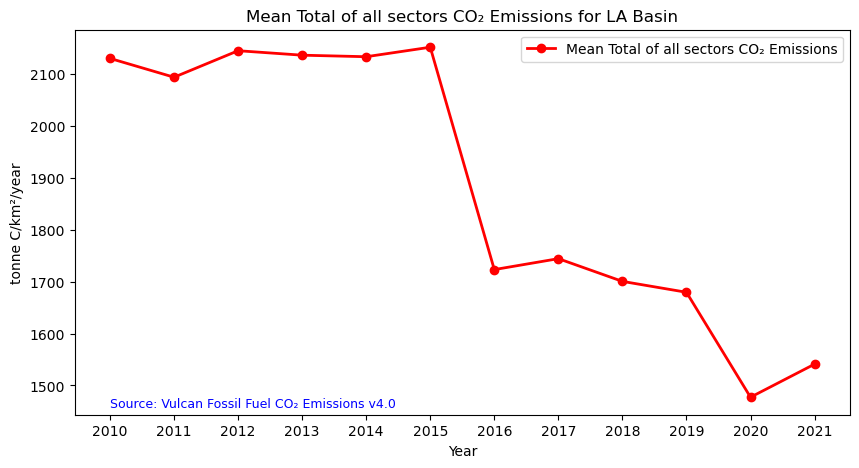

In [46]:
# Figure size: 10 is width, 5 is height.
fig = plt.figure(figsize=(10,5))
df = df.sort_values(by="datetime")

# Use which_stat to pick any statistic from our DataFrame to visualize
which_stat = "mean"

plt.plot(
    [d[0:4] for d in df["datetime"]], # X-axis: sorted datetime
    df[which_stat], # Y-axis: maximum CO₂
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=2, # Line width,
    marker='o', # Add circle markers at location of data points
    label=f"{which_stat.capitalize()} {items[0].assets[asset_name].title}", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Year")

# Insert label for the Y-axis
plt.ylabel("tonne C/km²/year")

# Insert title for the plot
plt.title(f"{which_stat.capitalize()} {items[0].assets[asset_name].title} for {aoi_name}")

# Add data citation
plt.text(
    min([d[0:4] for d in df["datetime"]]),           # X-coordinate of the text
    df[which_stat].min(),                  # Y-coordinate of the text
    # Text to be displayed
    f"Source: {collection.title}",      #example text            
    fontsize=9,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for Vulcan Fossil Fuel CO₂ Emissions, Version 4 dataset.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the total fossil fuel CO₂ emissions for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).